<a href="https://colab.research.google.com/github/AnimeshnikLeon/int-3/blob/main/ML3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle

In [5]:
# Загружаем данные
train = pd.read_excel('/content/drive/MyDrive/ML3/train.xlsx')
test = pd.read_excel('/content/drive/MyDrive/ML3/test.xlsx')

In [6]:
# Объединяем данные для общей структуры
train['dt'] = pd.to_datetime(train['dt'])
test['dt'] = pd.to_datetime(test['dt'])

train.set_index('dt', inplace=True)
test.set_index('dt', inplace=True)

# Декомпозиция временного ряда
decomposition = seasonal_decompose(train['Цена на арматуру'], model='additive', period=52)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

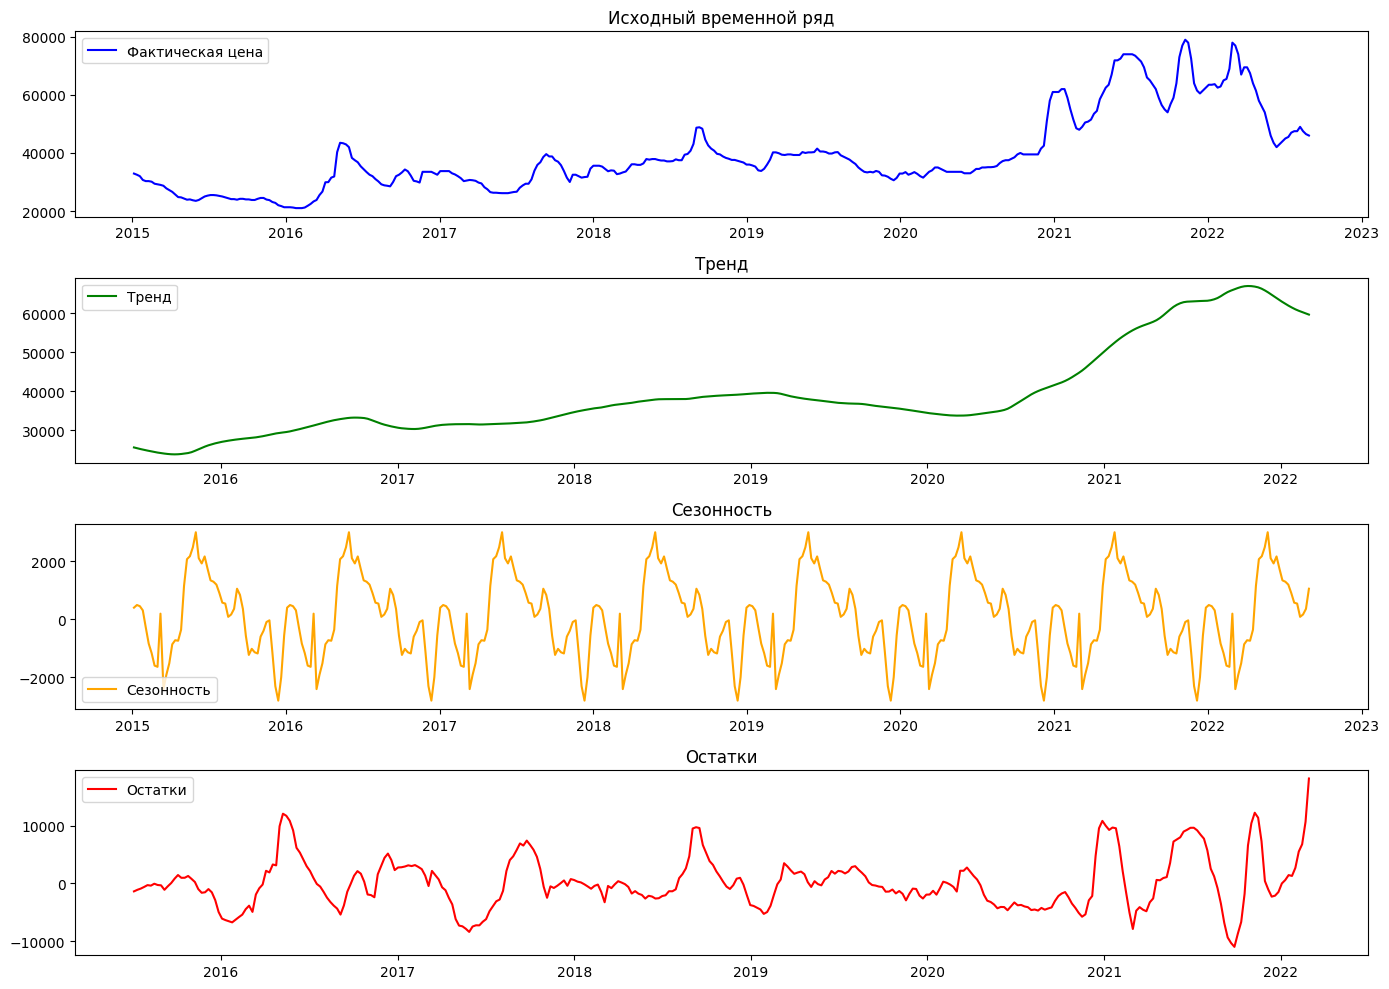

In [7]:
# Визуализация декомпозиции
plt.figure(figsize=(14, 10))
plt.subplot(4, 1, 1)
plt.plot(train['Цена на арматуру'], label='Фактическая цена', color='blue')
plt.title('Исходный временной ряд')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(trend, label='Тренд', color='green')
plt.title('Тренд')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Сезонность', color='orange')
plt.title('Сезонность')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(residual, label='Остатки', color='red')
plt.title('Остатки')
plt.legend()

plt.tight_layout()
plt.show()

Исходя из графиков можем сделать выводы что у продаж присутсвует сезонность и она влияет на остатки, которые увеличиваются к концу сезона. Так же за сезонностью следует и повышение фактической цены на арматуру, но она дополнительно растёт с восходящим трендом


In [40]:
# Обучаем модель SARIMA на train
model = SARIMAX(train['Цена на арматуру'],
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 52))
results = model.fit()

# Прогноз на длину тестового периода
n_weeks = len(test)
forecast = results.get_forecast(steps=n_weeks)
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


In [43]:
# Оценка качества модели
mae = mean_absolute_error(test['Цена на арматуру'], forecast_values)
rmse = np.sqrt(mean_squared_error(test['Цена на арматуру'], forecast_values))
rsqr = (r2_score(test['Цена на арматуру'], forecast_values))

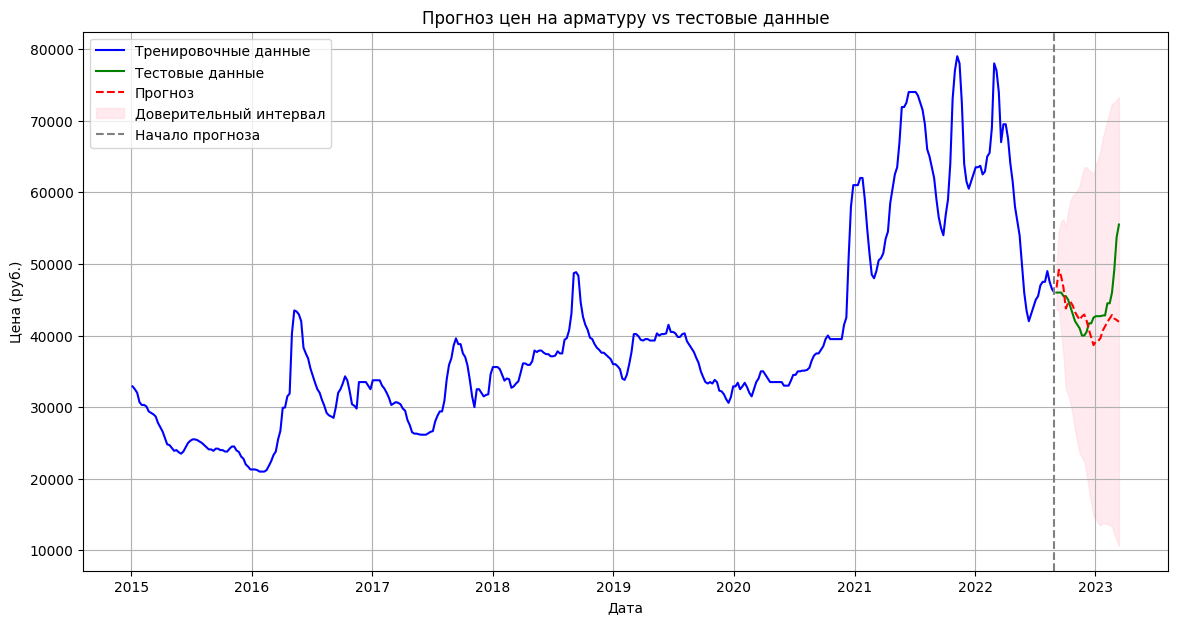

Рекомендация: Закупиться на 3 недель вперёд.
MAE (Средняя абсолютная ошибка): 2944.99
RMSE (Среднеквадратичная ошибка): 4184.65
R2 (коэффициент детерминации): -0.37


In [44]:
# Визуализация прогноза vs тестовые данные
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Цена на арматуру'], label='Тренировочные данные', color='blue')
plt.plot(test.index, test['Цена на арматуру'], label='Тестовые данные', color='green')
plt.plot(test.index, forecast_values, label='Прогноз', color='red', linestyle='--')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Доверительный интервал')
plt.axvline(x=train.index[-1], color='gray', linestyle='--', label='Начало прогноза')
plt.title('Прогноз цен на арматуру vs тестовые данные')
plt.xlabel('Дата')
plt.ylabel('Цена (руб.)')
plt.legend()
plt.grid()
plt.show()

# Рекомендация по объёму закупки
def recommend_volume(forecast_values):
    trend = np.sign(np.diff(forecast_values))
    if all(trend > 0):
        return 6  # Растущий тренд — закупаем на 6 недель
    elif all(trend < 0):
        return 1  # Падающий тренд — закупаем только на 1 неделю
    else:
        return 3  # Нейтральный тренд — закупаем на 3 недели

recommended_weeks = recommend_volume(forecast_values)

# Вывод результата
print(f'Рекомендация: Закупиться на {recommended_weeks} недель вперёд.')
print(f'MAE (Средняя абсолютная ошибка): {mae:.2f}')
print(f'RMSE (Среднеквадратичная ошибка): {rmse:.2f}')
print(f'R2 (коэффициент детерминации): {rsqr:.2f}')

In [19]:
# Сохраняем обученную модель в pickle
with open('sarima_model.pkl', 'wb') as f:
    pickle.dump(results, f)